# CSC412/2506 (Winter 2022) Probabilistic ML: Homework 3

- **Deadline**: 03/22 23:59
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.

## Your Info

- **Name:**
- **Student Number:**
- **Collaborators:**

# 1. [50pts] Stochastic Variational Inference in the TrueSkill Model

## Background

We'll continue working with [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2. Recall the model:


## Model definition

We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.


In [ ]:
!pip install wget
import os
import os.path
import matplotlib.pyplot as plt
import wget
import jax
import jax.numpy as np
import scipy.io
import scipy.stats
import matplotlib.pyplot as plt

from jax import jit, grad
# from jax.ops import index_update
from jax.random import PRNGKey, normal, split, uniform
from jax.scipy.stats import norm
from jax import random, vmap
from jax.example_libraries import optimizers
from tqdm import trange, tqdm_notebook
from functools import partial

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=931d82b4c4da6f15065f8db5b6ae86f65f3520d7374c972d88345228d5bd41a0
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


# 1.1 [0pts] Implementing the TrueSkill Model



This part was mostly done in Assignment 2. We will recall some useful functions.

**a)** The function $\texttt{log_joint_prior}$ computes the log of the prior, jointly evaluated over all player's skills.

In [ ]:
def log_joint_prior(zs_array):
    return np.sum(norm.logpdf(zs_array, 0.0, 1.0), axis=-1)

**b)** The function `logp_a_beats_b` that, given a pair of skills $z_a$ and $z_b$, evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.

To ensure numerical stability, we use the function `np.log1p` that computes $\log(1 + x)$ in a numerically stable way.  Or even better, use `np.logaddexp`.

In [ ]:
def logp_a_beats_b(z_a, z_b):
    return -np.logaddexp(0.0, z_b - z_a)

def log_prior_over_2_players(z1, z2):
    return norm.logpdf(z1, 0.0, 1.0) + norm.logpdf(z2, 0.0, 1.0)

def prior_over_2_players(z1, z2):
    return np.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return np.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 10.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_10_times(z1, z2):
    return np.exp(log_posterior_A_beat_B_10_times(z1, z2))

def log_posterior_beat_each_other_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) \
        + 10.* logp_a_beats_b(z1, z2) \
        + 10.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_10_times(z1, z2):
    return np.exp(log_posterior_beat_each_other_10_times(z1, z2))

The following functions will be used for plotting.  Note that `plot_2d_fun` can now take an optional second function, so you can compare two functions.

In [ ]:
# Plotting helper functions for free
def plot_isocontours(ax, func, xlimits=[-3, 3], ylimits=[-3, 3], numticks=101, cmap="summer"):
    x = np.linspace(*xlimits, num=numticks)
    y = np.linspace(*ylimits, num=numticks)
    X, Y = np.meshgrid(x, y)
    zs = func(X.ravel(), Y.ravel())
    Z = zs.reshape(X.shape)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
      plot_isocontours(ax, f2, cmap='winter')

    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([3, -3], [3, -3], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()    

## **1.2 [25pts]** Stochastic Variational Inference on Two Players and Toy Data

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.

In this question we will  approximate posterior distributions with gradient-based stochastic variational inference.

The parameters are $\phi = (\mu,\log(\sigma))$. Notice that instead of $\sigma$ (which is constrained to be positive), we work with $\log(\sigma)$, removing the constraint. This way, we can do unconstrained gradient-based optimization.



**a) [15pts]** Implement the missing lines in the below code, to complete the evidence lower bound function and the reparameterized sampler for the approximate posterior.

Hint 1: You must use the reparametrization trick in your sampler if you want your gradients to be unbiased.

Hint 2: Instead of including batch dimensions, you can simply use the `vmap` higher-order function, which takes in a function and returns another one that broadcasts the first function along a new axis.

Hint 3: If you're worried you got these wrong, you can check that the sampler matches the log pdf by plotting a histogram of samples against a plot of the pdf.

In [ ]:
def diag_gaussian_sample(rng, mean, log_std):
  # Take a single sample from a diagonal multivariate Gaussian.
  return random.normal(rng, shape=mean.shape) * np.exp(log_std) + mean
  # You might want to use random.normal(), but remember
  # you must use the reparameterization trick.  Also remember that
  # we are parameterizing the _log_ of the standard deviation.

def diag_gaussian_logpdf(x, mean, log_std):
  # Evaluate the density of single point on a diagonal multivariate Gaussian.
  return np.sum(norm.logpdf(x, mean, np.exp(log_std)), axis=-1)

def elbo(logprob, rng, mean, log_std):
  # Single-sample Monte Carlo estimate of the variational lower bound.
  sampled_zs = diag_gaussian_sample(rng, mean, log_std)
  return logprob(sampled_zs) - diag_gaussian_logpdf(sampled_zs, mean, log_std)

def batch_elbo(logprob, rng, params, num_samples):
  # Average over a batch of random samples. 
  rngs = random.split(rng, num_samples)
  vectorized_elbo = vmap(partial(elbo, logprob), in_axes=(0, None, None))
  elbo_estimates = vectorized_elbo(rngs, *params)
  return np.mean(elbo_estimates, axis=0)
  # Use simple Monte Carlo to combine your estimates
  


**b) [4pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters and an array of game outcomes, and returns an unbiased estimate of the negative elbo using $\texttt{num_samples_per_iter}$ samples, to approximate the joint posterior over skills conditioned on observing player A winning 10 games.

Note: We want a _negative_ ELBO estimate, because the convention in optimization is to minimize functions, and we want to maximize the ELBO.

In [ ]:
# Hyperparameters
num_players = 2
n_iters = 800
stepsize = 0.0001
num_samples_per_iter = 50
key = PRNGKey(0)

def log_posterior_A_beat_B_10_times_1_arg(z1z2):
  return log_posterior_A_beat_B_10_times(z1z2[0], z1z2[1])

def objective(params, t):  # The loss function to be minimized.
  rng = random.PRNGKey(t)
  return -batch_elbo(log_posterior_A_beat_B_10_times_1_arg, rng, params, num_samples_per_iter)
  # Hint:  This can be done in one line.

**c) [1pts]** Initialize a set of variational parameters and optimize them to approximate the joint where we observe player A winning 10 games. Report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Hint:  Any initialization should be fine.  How many variational parameters do you need?

Optimizing variational parameters...


  3%|▎         | 26/800 [00:05<01:56,  6.66it/s] 

Iteration 0 lower bound 4.530764102935791
Iteration 25 lower bound 8.14537525177002
Iteration 50 lower bound 3.396458625793457


 16%|█▌        | 126/800 [00:05<00:14, 45.63it/s]

Iteration 75 lower bound 3.1385209560394287
Iteration 100 lower bound 2.922302722930908
Iteration 125 lower bound 3.0605359077453613


 22%|██▏       | 176/800 [00:05<00:08, 72.36it/s]

Iteration 150 lower bound 2.961040496826172
Iteration 175 lower bound 2.931621551513672
Iteration 200 lower bound 2.929612398147583


 34%|███▍      | 276/800 [00:06<00:03, 137.74it/s]

Iteration 225 lower bound 3.0404036045074463
Iteration 250 lower bound 2.908095121383667
Iteration 275 lower bound 3.02541184425354


 41%|████      | 326/800 [00:06<00:02, 170.80it/s]

Iteration 300 lower bound 2.933720111846924
Iteration 325 lower bound 2.9159774780273438
Iteration 350 lower bound 3.0472412109375


 51%|█████     | 409/800 [00:06<00:01, 205.28it/s]

Iteration 375 lower bound 3.024594306945801
Iteration 400 lower bound 2.90017032623291


 60%|█████▉    | 476/800 [00:06<00:01, 234.85it/s]

Iteration 425 lower bound 3.0051774978637695
Iteration 450 lower bound 2.9029064178466797
Iteration 475 lower bound 3.0870471000671387


 70%|██████▉   | 557/800 [00:07<00:00, 265.77it/s]

Iteration 500 lower bound 2.9341259002685547
Iteration 525 lower bound 2.8127903938293457
Iteration 550 lower bound 3.142521381378174


 78%|███████▊  | 626/800 [00:07<00:00, 257.49it/s]

Iteration 575 lower bound 3.099686861038208
Iteration 600 lower bound 2.7920753955841064
Iteration 625 lower bound 2.9612951278686523


 84%|████████▍ | 676/800 [00:07<00:00, 282.48it/s]

Iteration 650 lower bound 3.0898993015289307
Iteration 675 lower bound 2.9484963417053223
Iteration 700 lower bound 2.8852996826171875


100%|██████████| 800/800 [00:07<00:00, 100.70it/s]

Iteration 725 lower bound 2.948615074157715
Iteration 750 lower bound 2.867049217224121
Iteration 775 lower bound 2.976224184036255


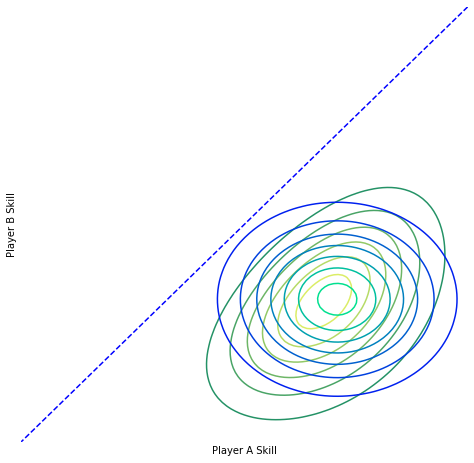

<Figure size 432x288 with 0 Axes>

In [ ]:
def callback(params, t):
  if t % 25 == 0:
    print("Iteration {} lower bound {}".format(t, objective(params, t)))

# Set up optimizer.
D = 2
init_mean     = np.zeros(D)
init_log_std  = np.ones(D) 
init_params = (init_mean, init_log_std)
opt_init, opt_update, get_params = optimizers.momentum(step_size=0.1, mass=0.9)
opt_state = opt_init(init_params)

@jit
def update(i, opt_state):
    params = get_params(opt_state) 
    gradient = grad(objective)(params, i)
    return opt_update(i, gradient, opt_state)

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    opt_state = update(t, opt_state)
    params = get_params(opt_state)
    callback(params, t)


def approx_posterior_2d(z1, z2):
    # The approximate posterior
    mean, logstd = params
    return np.exp(diag_gaussian_logpdf(np.array([z1, z2]), mean, logstd))

approx_posterior_2d_batched = vmap(approx_posterior_2d, in_axes=(0, 0))

plot_2d_fun(posterior_A_beat_B_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d_batched)

**d) [3pt]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters and an array of game outcomes, and returns a negative elbo estimate using simple Monte carlo with $\texttt{num_samples_per_iter}$ samples, to approximate the joint where we observe player A winning 10 games and player B winning 10 games.

Hint:  You can find analogous functions in the code above.


In [ ]:
# Hyperparameters
n_iters = 100
stepsize = 0.0001
num_samples_per_iter = 50
key = PRNGKey(0)

def log_posterior_beat_each_other_10_times_1_arg(z1z2):
  return log_posterior_beat_each_other_10_times(z1z2[0], z1z2[1])

def objective(params, t):
  rng = random.PRNGKey(t)
  return -batch_elbo(log_posterior_beat_each_other_10_times_1_arg, rng, params, num_samples_per_iter)

**e) [2pt]** Run the code below to optimize, and report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Write one or two sentences describing the joint settings of skills that are plausible under the true posterior, but which are not plausible under the approximate posterior.

Finally, answer with one or two sentences:  Would changing the variational approximate posterior from a fully-factorized (diagonal covariance) Gaussian to a non-factorized (fully parameterized covariance) Gaussian make a better approximation in this instance?

Optimizing variational parameters...


  1%|          | 1/100 [00:02<03:56,  2.39s/it]

Iteration 0 lower bound 17.624523162841797
Iteration 25 lower bound 15.784347534179688


100%|██████████| 100/100 [00:02<00:00, 36.04it/s]

Iteration 50 lower bound 15.823676109313965
Iteration 75 lower bound 15.860443115234375


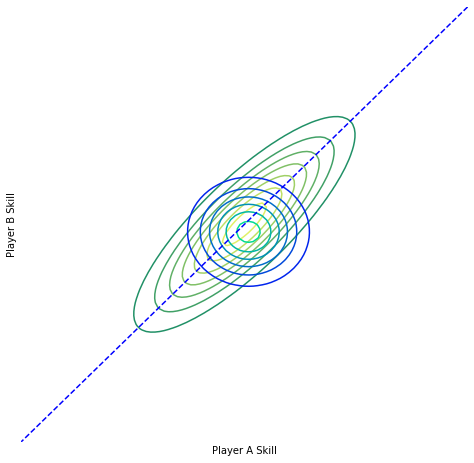

<Figure size 432x288 with 0 Axes>

In [ ]:
@jit
def update(i, opt_state):
    params = get_params(opt_state)
    gradient = grad(objective)(params, i)
    return opt_update(i, gradient, opt_state)

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    opt_state = update(t, opt_state)
    params = get_params(opt_state)
    callback(params, t)

def approx_posterior_2d(z1, z2):
    mean, logstd = params
    return np.exp(diag_gaussian_logpdf(np.array([z1, z2]), mean, logstd))

approx_posterior_2d_batched = vmap(approx_posterior_2d, in_axes=(0, 0))

plot_2d_fun(posterior_beat_each_other_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d_batched)


Answer: 

Under the true posterior, it is plausible that both Player A and B skills are bad, or very good. However, under the approximate posterior, this is not plausible, since the estimated A and B skills are both close to a middle range of values, according to its circle-shaped contours.

In this instance, changing the variational approximate posterior from a fully-factorized Gaussian to a non-factorized Gaussian makes a better approximation, since the correlation between the player A and player B skills will also be estimated in a non-factorized Gaussian approximation. For example in this case, since they beat each other 10 times, then it is plausbile that if A has bad skill then B is also likely to be bad, otherwise B is also likely to be good, therefore a non-factorized Gaussian may be a better approximation. 

## 1.3 [25pts] Approximate inference conditioned on real data

The dataset from $\texttt{tennis_data.mat}$ contains data on 1801 tennis games amongst 107 players:
 - W is a 107 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - G is a 1801 by 2 matrix of game outcomes (actually tennis matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.





In [ ]:
wget.download("https://probmlcourse.github.io/csc412/assignments/assignment_2/tennis_data.mat")
data = scipy.io.loadmat('tennis_data.mat')

games = data['G'] - 1 # A list of pairs of player numbers, representing game outcomes. (shape (1081, 2))
names = data['W']     # A list of names of players, corresponding to the player numbers. (shape (107, 1))

print(games[0,:])
print(names[0])

[0 1]
[array(['Rafael-Nadal'], dtype='<U12')]




**a) [0pt]** Assuming all game outcomes are i.i.d. conditioned on all players' skills, the function $\texttt{log_games_likelihood}$ takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihood for all those observations given all the skills.


In [ ]:
def log_games_likelihood(zs, games):
  # matches is an array of size (num_games x 2)
  # zs is an array of size (num_players, num_samples)

  winning_player_ixs = games[:,0]
  losing_player_ixs = games[:,1]

  winning_player_skills = zs[winning_player_ixs] 
  losing_player_skills = zs[losing_player_ixs] 
  log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills) 
  return np.sum(log_likelihoods)

In [ ]:
def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

**b) [4pt]** Write a new objective function like the one from the previous question. 

Below, we initialize a variational distribution and fit it to the joint distribution with all the observed tennis games from the dataset. Report the final negative ELBO estimate after optimization.

In [ ]:
# Hyperparameters
num_players = 107
n_iters = 500
stepsize = 0.0001
num_samples_per_iter = 150
key = PRNGKey(0)

def objective(params, t):
  rng = random.PRNGKey(t)
  return -batch_elbo(log_joint_probability, rng, params, num_samples_per_iter)

**c) [1pts]** Optimize, and report the final loss. 

In [ ]:
# Set up optimizer.
init_mean = np.zeros(num_players)
init_std  = np.zeros(num_players)
init_params = (init_mean, init_std)
opt_init, opt_update, get_params = optimizers.momentum(step_size=0.1, mass=0.9)
opt_state = opt_init(init_params)

@jit
def update(i, opt_state):
    params = get_params(opt_state)
    gradient = grad(objective)(params, i)
    return opt_update(i, gradient, opt_state)

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    opt_state = update(t, opt_state)
    params = get_params(opt_state)
    callback(params, t)


Optimizing variational parameters...


 10%|█         | 51/500 [00:11<01:12,  6.16it/s] 

Iteration 0 lower bound 1186.4822998046875
Iteration 25 lower bound 1172.82373046875
Iteration 50 lower bound 1146.538330078125


 20%|██        | 101/500 [00:11<00:27, 14.52it/s]

Iteration 75 lower bound 1144.3675537109375
Iteration 100 lower bound 1144.565673828125
Iteration 125 lower bound 1144.3046875


 40%|████      | 201/500 [00:12<00:07, 40.75it/s]

Iteration 150 lower bound 1144.0537109375
Iteration 175 lower bound 1144.3070068359375
Iteration 200 lower bound 1144.236328125


 48%|████▊     | 242/500 [00:12<00:04, 56.95it/s]

Iteration 225 lower bound 1144.291748046875
Iteration 250 lower bound 1143.934814453125


 65%|██████▌   | 326/500 [00:12<00:01, 96.37it/s]

Iteration 275 lower bound 1144.21728515625
Iteration 300 lower bound 1144.195068359375
Iteration 325 lower bound 1144.046875


 78%|███████▊  | 390/500 [00:12<00:00, 139.29it/s]

Iteration 350 lower bound 1144.3035888671875
Iteration 375 lower bound 1144.3499755859375
Iteration 400 lower bound 1144.8079833984375


 90%|█████████ | 451/500 [00:13<00:00, 131.61it/s]

Iteration 425 lower bound 1144.3662109375
Iteration 450 lower bound 1143.9383544921875


100%|██████████| 500/500 [00:13<00:00, 37.29it/s] 

Iteration 475 lower bound 1144.51611328125


**d) [1pt]** Plot the approximate mean and variance of all players, sorted by skill.

In [ ]:
mean_skills, logstd_skills = params
# Hint: You don't need to do simple Monte Carlo here.
order = np.argsort(mean_skills)

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")
plt.errorbar(range(107), mean_skills[order], logstd_skills[order])

**e) [2pts]** List the names of the 10 players with the highest mean skill under the variational model.


In [ ]:
for i in range(1,11):
    print(names[order[107-i]][0][0])

**f) [1pt]** Plot the joint posterior over the skills of Roger Federer and Rafael Nadal.

In [ ]:
nadal_ix = 0
federer_ix = 4
print(names[nadal_ix])
print(names[federer_ix])

fig = plt.figure(figsize=(8,8), facecolor='white')

# Label each with "<player> Skill"
plt.xlabel("Roger Federer Skill") 
plt.ylabel("Rafael Nadal Skill") 

plt.plot([3, -3], [3, -3], 'b--') # Line of equal skill

rngs = random.split(random.PRNGKey(t), 100)
samples = vmap(diag_gaussian_sample, in_axes=(0, None, None))(rngs, *params)

# Hint:  Use plt.scatter()
plt.scatter(samples[:, nadal_ix], samples[:, federer_ix])


**g) [8pts]** Derive the exact probability under a factorized Gaussian over two players’ skills that one has higher skill than the other, as a function of the two means and variances over their skills. Express your answer in terms of the cumulative distribution function of a one-dimensional Gaussian random variable.

- Hint 1: Use a linear change of variables $y_A, y_B = z_A − z_B , z_B$. What does the line of equal skill look like after this transformation?
- Hint 2: If $X \sim \mathcal N (\mu, \Sigma)$, then $AX \sim \mathcal N (A\mu, A\Sigma A^T)$ where $A$ is a linear transformation.
- Hint 3: Marginalization in Gaussians is easy: if $X \sim \mathcal N (\mu, \Sigma)$, then the $i$th element of $X$ has a
marginal distribution $X_i \sim \mathcal N (\mu_i , \Sigma_{ii})$.

Your answer here.

**h) [2pts]** Compute the probability under your approximate posterior that Roger Federer has higher skill than Rafael Nadal. Compute this quantity exactly using the formula you just derived above, and also estimate it using simple Monte Carlo with 10000 examples.

Hint:  You might want to use `jax.scipy.stats.norm.cdf` for the exact formula.

In [ ]:
# TODO

**i) [2pts]** Compute the probability that Roger Federer is better than the player with the lowest mean skill. Compute this quantity exactly, and then estimate it using simple Monte Carlo with 10000 examples.


In [ ]:
# TODO

**j) [2 pts]** Imagine that we knew ahead of time that we were examining the skills of top tennis players, and so changed our prior on all players to Normal(10, 1) and re-ran our approximate inference from scratch. Would that change the answer of either of the previous 2 questions, in expectation?

Your answer here.
This would not change the answer of either the previous 2 questions, in expectation.

**k) [2 pts]** Based on all the plots and results in this assignment and HW2, which approximate inference method do you suspect is producing a better overall approximation to the true posterior over all skills conditioned on all games?  Give a short explanation.

Your answer here.
MCMC has the better overall approximation to the true posterior over all skills conditioned on all games.

# 2. [50pts] Expectation-Maximization (EM) algorithm

In [ ]:
%matplotlib inline
import scipy
import numpy as np
import itertools
import matplotlib.pyplot as plt

## 2.1 [7pts] Generating the Data

**a) [5pts]** First, we will generate some data for this problem. Set the number of points $N=400$, their dimension $D=2$, and the number of clusters $K=2$, and generate data from the distribution $p(x|z=k) = \mathcal{N}(\mu_k, \Sigma_k)$.
  Sample $200$ data points for $k=1$ and 200 for $k=2$, with

  $$
    \mu_1=
    \begin{bmatrix}
      0.1 \\
      0.1
    \end{bmatrix}
    \ \text{,}\
    \mu_2=
    \begin{bmatrix}
      6.0 \\
      0.1
    \end{bmatrix}
    \ \text{ and }\
    \Sigma_1=\Sigma_2=
    \begin{bmatrix}
      10       & 7 \\
      7 & 10
    \end{bmatrix}
  $$
  Here, $N=400$. If you generate the data, you already know which sample comes from which class. Complete the following statements and run to generate.

  Hint: you can use `np.random.multivariate_normal`.

In [ ]:
num_samples = 400
cov = np.array([[10, 7], [7, 10]])
mean_1 = np.array([0.1, 0.1])
mean_2 = np.array([6.0, 0.1])

x_class1 = np.random.multivariate_normal(mean_1, cov, num_samples//2)
x_class2 = np.random.multivariate_normal(mean_2, cov, num_samples//2)
xy_class1 = np.append(x_class1, np.ones((num_samples//2, 1)), axis=1)
xy_class2 = np.append(x_class2, np.ones((num_samples//2, 1))*2, axis=1)

data_full = np.append(xy_class1, xy_class2, axis=0)
np.random.shuffle(data_full)
data = data_full[:, :2]
labels = data_full[:, 2]

**b) [2pts]** Make a scatter plot of the data points showing the true cluster assignment of each point using different color codes and shape (x for first class and circles for second class):

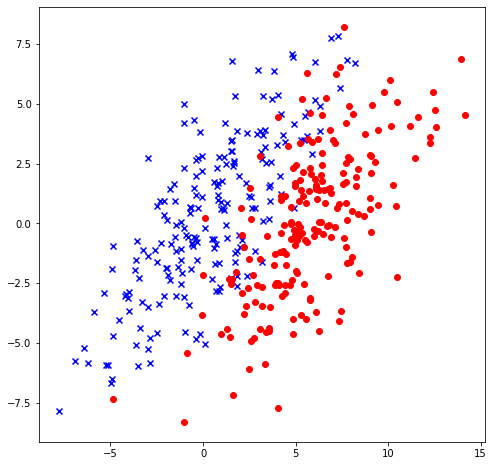

In [ ]:
fig = plt.figure(figsize=(8,8), facecolor='white')
# first class, x shape
plt.scatter(x_class1[:, 0], x_class1[:, 1], color = 'b', marker = "x")
# second class, circle shape
plt.scatter(x_class2[:, 0], x_class2[:, 1], color = 'r', marker = "o")       

## 2.2 [14pts] Implement and Run K-Means algorithm

Now, we assume that the true class labels are not known. Implement the k-means algorithm for this problem.
  Write two functions: `km_assignment_step`, and `km_refitting_step` as given in the lecture (Here, `km_` means k-means).
  Identify the correct arguments, and the order to run them. Initialize the algorithm with
  $$
    \hat\mu_1=
    \begin{bmatrix}
      0.0 \\
      0.0
    \end{bmatrix}
    \ \text{,}\
    \hat\mu_2=
    \begin{bmatrix}
      1.0 \\
      1.0
    \end{bmatrix}
  $$
  and run it until convergence.
  Show the resulting cluster assignments on a scatter plot either using different color codes or shape or both.
  Also plot the cost (distortion in lecture slides) vs. the number of iterations. Report your misclassification error. 

**a) [2pts]** Complete the `cost` function.

In [ ]:
def cost(data, R, Mu):
    N, D = data.shape
    K = Mu.shape[1]
    data1 = np.repeat(data[:, :, np.newaxis], K, axis=2)
    Mu1 = np.repeat(Mu[np.newaxis, :, :], N, axis=0)
    R1 = np.repeat(R[:, np.newaxis, :], D, axis=1)

    J = np.sum(np.sum(R1*(Mu1 - data1)*(Mu1 - data1), axis=2), axis=0)
    
    return J

**b) [4pts]** K-Means assignment step.

In [ ]:
def km_assignment_step(data, Mu):
    """ Compute K-Means assignment step
    
    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the cluster means locations
    
    Returns:
        R_new: a NxK matrix of responsibilities
    """
    
    N, D = data.shape # TODO: Number of datapoints and dimension of datapoint
    K = Mu.shape[1] # number of clusters
    r = ... # TODO
    # TODO assign all r[:, k]
    
    data1 = np.repeat(data[:, :, np.newaxis], K, axis=2)
    Mu1 = np.repeat(Mu[np.newaxis, :, :], N, axis=0)
    
    arg_min = np.argmin((data1 - Mu1)*(data1 - Mu1), axis=2) # TODO: argmax/argmin along dimension 1
    R_new = np.zeros((N, K)) # TODO: Set to zeros/ones with shape (N, K)
    R_new[:, arg_min] = 1 # TODO Assign to 1
    return R_new

**c) [2pts]** K-Means refitting step.

In [ ]:
# TODO: K-means Refitting Step
def km_refitting_step(data, R, Mu):
    """ Compute K-Means refitting step.
    
    Args:
        data: a NxD matrix for the data points
        R: a NxK matrix of responsibilities
        Mu: a DxK matrix for the cluster means locations
    
    Returns:
        Mu_new: a DxK matrix for the new cluster means locations
    """
    N, D = data.shape # TODO: number of datapoints and dimension of datapoint
    K = Mu.shape[1] # TODO: number of clusters
    Mu_new = data.T @ R / np.sum(R, axis=0)
    return Mu_new

**d) [4pts]** Run this cell to call the K-Means algorithm.

In [ ]:
N, D = 400, 2
K = 2
max_iter = 100
class_init = np.append(np.ones(200), np.ones(200)*2, axis=0)
R = np.zeros(400)

Mu = np.zeros([D, K])
Mu[:, 1] = 1.
R.T.dot(data), np.sum(R, axis=0)

for it in range(max_iter):
    R = km_assignment_step(data, Mu)
    Mu = km_refitting_step(data, R, Mu)
    print(it, cost(data, R, Mu))

class_1 = data[np.argwhere(R[:, 0] == 1)]
class_2 = data[np.argwhere(R[:, 1] == 1)]

**e) [2pts]** Make a scatterplot for the data points showing the K-Means cluster assignments of each point.


In [ ]:
fig = plt.figure(figsize=(8,8), facecolor='white')
# first class, x shape
plt.scatter(class_1[:, 0], class_1[:, 1], color = 'b', marker = "x")
# second class, circle shape
plt.scatter(class_2[:, 0], class_2[:, 1], color = 'r', marker = "o")   

## 2.3 [21pts] Implement EM algorithm for Gaussian mixtures

Next, implement the EM algorithm for Gaussian mixtures. Write three functions: `log_likelihood`, `gm_e_step`, and `gm_m_step` as given in the lecture.
  - Identify the correct arguments, and the order to run them.
  - Initialize the algorithm with the same initialization as in Q2.1 for the means, and with $\hat\Sigma_1=\hat\Sigma_2=I$, and $\hat\pi_1=\hat\pi_2$ for the covariances.
    
Run the algorithm until convergence and show the resulting cluster assignments on a scatter plot either using different color codes or shape or both. Also plot the log-likelihood vs. the number of iterations. Report your misclassification error.

In [ ]:
def normal_density(x, mu, Sigma):
    return np.exp(-.5 * np.dot(x - mu, np.linalg.solve(Sigma, x - mu))) \
        / np.sqrt(np.linalg.det(2 * np.pi * Sigma))

**a) [5pts]** Log-Likelihood.

In [ ]:
def log_likelihood(data, Mu, Sigma, Pi):
    """ Compute log likelihood on the data given the Gaussian Mixture Parameters.
    
    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    
    Returns:
        L: a scalar denoting the log likelihood of the data given the Gaussian Mixture
    """
    N, D = data.shape  # TODO Number of datapoints and dimension of datapoint
    K = Mu.shape[1] # TODO number of mixtures
    L, T = 0., 0.
    # TODO: given n, k, compute the likelihood from the k-th Gaussian weighted by the mixing coefficients
    L = np.log(Pi.T @ np.random.normal(Mu, Sigma))
    return L

**b) [5pts]** Gaussian Mixture Expectation Step.

In [ ]:
def gm_e_step(data, Mu, Sigma, Pi):
    """ Gaussian Mixture Expectation Step.

    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    
    Returns:
        Gamma: a NxK matrix of responsibilities 
    """
    N, D = data.shape # TODO Number of datapoints and dimension of datapoint
    K = Mu.shape[1] # TODO number of mixtures
    Gamma = np.zeros((N, K)) # TODO zeros of shape (N,K), matrix of responsibilities

    # TODO: given n, k, normalize by sum across second dimension (mixtures)
    Gamma = (Pi.T @ np.random.normal(Mu, Sigma))/log_likelihood(data, Mu, Sigma, Pi)

    return Gamma

**c) [5pts]** Gaussian Mixture Maximization Step.

In [ ]:
def gm_m_step(data, Gamma):
    """ Gaussian Mixture Maximization Step.

    Args:
        data: a NxD matrix for the data points
        Gamma: a NxK matrix of responsibilities 
    
    Returns:
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    """
    N, D = data.shape # TODO Number of datapoints and dimension of datapoint
    K = Gamma.shape[1]  # TODO number of mixtures
    Nk = np.sum(Gamma, axis=0) # TODO Sum along first axis 
    Mu = data.T @ Gamma / Nk # TODO
    Sigma = 1/Nk * Gamma @ (data - Mu) @ (data - Mu).T# TODO

    # TODO: fill in Sigma[k] for each k

    Pi = Nk/N # TODO
    return Mu, Sigma, Pi

**d) [4pts]** Run this cell to call the Gaussian Mixture EM algorithm.

In [ ]:
N, D = 400, 2
K = 2
Mu = np.zeros([D, K])
Mu[:, 1] = 1.
Sigma = [np.eye(2), np.eye(2)]
Pi = np.ones(K) / K
Gamma = np.zeros([N, K]) # Gamma is the matrix of responsibilities 

max_iter  = 200

for it in range(max_iter):
    Gamma = gm_e_step(data, Mu, Sigma, Pi)
    Mu, Sigma, Pi = gm_m_step(data, Gamma)

class_1 = np.where(Gamma[:, 0] == 1)
class_2 = np.where(Gamma[:, 1] == 1)

**e) [2pts]** Make a scatterplot for the data points showing the Gaussian Mixture cluster assignments of each point

In [ ]:
fig = plt.figure(figsize=(8,8), facecolor='white')
# first class, x shape
plt.scatter(class_1[:, 0], class_1[:, 1], color = 'b', marker = "x")
# second class, circle shape
plt.scatter(class_2[:, 0], class_2[:, 1], color = 'r', marker = "o") 

## 2.4 [8pts] Comment on findings + additional experiments

Comment on the results:

* Compare the performance of k-Means and EM based on the resulting cluster assignments. [2pts]
* Compare the performance of k-Means and EM based on their convergence rate. What is the bottleneck for which method? [2pts]
* Experiment with 5 different data realizations (generate new data), run your algorithms, and summarize your findings. Does the algorithm performance depend on different realizations of data? [3pts]
* Comment on what might happen as you increase the number $K$ of clusters. [1pts]
 


Your answer here.

EM algorithm performs better than k-means on the clustering assignments.

EM algorithm has a slower convergence rate than k-Means. The bottleneck of EM algorithm is the M-step that reestimate the model parameters, especially the variance is the bottleneck.

In [ ]:
# your code here, if you have any

If the number K of clusters increases, it is likely to classify data within same group to different groups.